# Imports

In [21]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler

sys.path.append("../src")

# Constants

In [22]:
train_path = "../data/selected_train.csv"
train_not_norm_path = "../data/train_not_normalized.csv"

# Loading data

In [23]:
take_normalized_data = False

In [24]:
def preprocessing_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

In [27]:
if take_normalized_data:
    # Already preprocessed data
    df_data = pd.read_csv(train_path, sep=",")
    X = df_data[df_data.columns.difference(['label'])].values
    
else:
    # Load data not preprocessed and preprocess it
    df_data = pd.read_csv(train_not_norm_path, sep=",")
    X = df_data[df_data.columns.difference(['label'])].values
    X = preprocessing_data(X)

y = df_data["label"].values

## Train test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (20, 56)
X_test  shape: (9, 56)


# GMM
## Define the model

In [30]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000)

## Fit data

In [31]:
gmm.fit(X_train, y_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

## Test model

In [32]:
y_pred  = gmm.predict(X_test)
y_proba = gmm.predict_proba(X_test)

print("y test:", y_test)
print("y_pred:", y_pred)

y test: [2 2 1 1 2 1 0 2 0]
y_pred: [0 0 0 2 0 2 0 0 0]


## Confusion matrix

In [33]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[2, 0, 0],
       [1, 0, 2],
       [4, 0, 0]])

# GMM after PCA

## PCA over dataset 

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1','PC 2'])

In [36]:
finalDf = pd.concat([principalDf, df_data[['label']]], axis = 1)

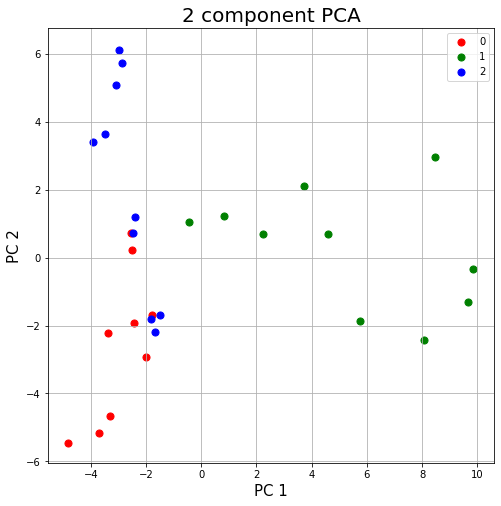

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## GMM over 2D PCA

In [38]:
X_pca = finalDf[finalDf.columns.difference(['full_label', 'label'])].values
y_pca = finalDf["label"].values

In [39]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3)

## Fit data from PCA

In [40]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000, tol=1e-8, init_params="random")

In [41]:
gmm = gmm.fit(X_pca, y_pca)

## Test model

In [42]:
y_pred_pca  = gmm.predict(X_test_pca)
y_proba_pca = gmm.predict_proba(X_pca)

#print("y test:", y_test_pca)
print("y_proba:", y_proba_pca)
print("y", y_pred_pca)
print("y", y_pca)

y_proba: [[3.80656993e-200 9.99999547e-001 4.52692323e-007]
 [9.99892645e-001 1.00982793e-037 1.07354858e-004]
 [0.00000000e+000 9.99988332e-001 1.16683567e-005]
 [0.00000000e+000 1.00000000e+000 3.22858111e-015]
 [0.00000000e+000 1.91238502e-046 1.00000000e+000]
 [1.35353749e-259 9.99544580e-001 4.55419623e-004]
 [4.01283242e-001 5.97866919e-001 8.49838716e-004]
 [9.77804448e-001 1.28995579e-002 9.29599406e-003]
 [0.00000000e+000 9.99999642e-001 3.57924371e-007]
 [7.82914932e-006 9.99089176e-001 9.02994855e-004]
 [8.17002903e-025 3.69164127e-007 9.99999631e-001]
 [3.00989254e-288 9.99726647e-001 2.73352705e-004]
 [8.97448972e-174 9.99905545e-001 9.44549912e-005]
 [9.72998223e-001 3.59744428e-013 2.70017770e-002]
 [7.44900131e-060 6.04376524e-016 1.00000000e+000]
 [9.53962013e-001 1.54463865e-004 4.58835235e-002]
 [4.79168918e-186 9.99992453e-001 7.54735361e-006]
 [1.07518585e-008 9.97541083e-001 2.45890634e-003]
 [4.96911071e-001 5.02290229e-001 7.98699607e-004]
 [0.00000000e+000 9.99

## Confusion matrix

In [43]:
cm = confusion_matrix(y_test_pca, y_pred_pca)
cm

array([[0, 4, 0],
       [0, 0, 1],
       [0, 4, 0]])

## Contour 

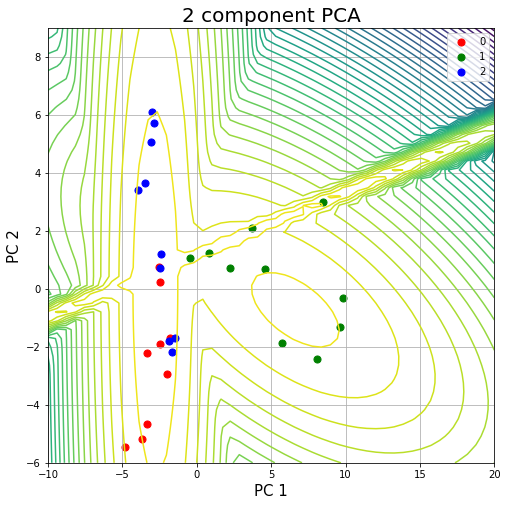

In [47]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Contour
X, Y = np.meshgrid(np.linspace(-10, 20), np.linspace(-6, 9))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape((len(X),len(Y)))
ax.contour(X, Y, Z, levels=40)


plt.show()